# `unshrink`: Debiasing ML Predictions for Causal Inference

**unshrink** is a Python package for correcting attenuation bias in machine learning predictions when used for downstream causal inference tasks.

## The Problem

When ML models are used to impute outcomes for causal analysis, the predicted values tend to be "shrunk" toward the mean compared to the true values. This shrinkage attenuates treatment effect estimates, leading to biased causal conclusions.

## The Solution

This package implements debiasing methods from [Pettersson, Jerzak & Daoud (2025)](https://arxiv.org/abs/2508.01341) that correct for this attenuation without requiring additional ground truth data at test time:

- **TweedieDebiaser**: Uses Tweedie's formula with KDE-based score estimation
- **LccDebiaser**: Linear Calibration Correction via inverse linear regression

Both follow a simple sklearn-like API: `fit()` on calibration data, then `debiased_mean()` or `debiased_ate()` on test predictions.

---


# Demo: California Housing dataset 

To show how to use the `unshrink` package, we will run through a minimal version of the intended pipeline, using the classic [California Housing Dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset). The idea is to showcase the attenuation bias introduced when we use model predicted outcomes over

This dataset contains aggregated census-block-level housing and demographic information for California, derived from the 1990 U.S. Census. Each row represents a geographic region (a census block group), and the target variable is the median house value in that region. Features include measures of population, housing characteristics, and geographic location.

## Upstream: Model fitting

We start out by retrieving the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load California housing
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
y = df['MedHouseVal'].values

df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


We drop the target variable "MedHouseVal" from the input data and divide the samples into train and test sets. For reasons that will become clear later, we also extract the variable "MedInc" (the regions median income) from the input data.

In [2]:
# Drop target (MedHouseVal) and treatment (MedInc) variables from model inputs
X = df.drop(columns=['MedHouseVal', 'MedInc'])

# Keep MedInc for later
medinc = df['MedInc'].values

# Train/test split
X_train, X_test, y_train, y_test, medinc_train, medinc_test = train_test_split(
    X, y, medinc, test_size=0.3, random_state=0
)

We now fit a simple Random Forest regression model on the training data.

In [3]:
rf = RandomForestRegressor(
    n_estimators=100, max_depth=8, random_state=0, n_jobs=-1
)
rf.fit(X_train, y_train)
y_hat_test = rf.predict(X_test)

# Evaluate model performance on the test set
print('Upstream test performance:')
print(f' R2: {r2_score(y_test, y_hat_test):.3f}')
print(f' RMSE: {np.sqrt(mean_squared_error(y_test, y_hat_test)):.3f}')

Upstream test performance:
 R2: 0.725
 RMSE: 0.605


The model appears to do a decent job of predicting the region's median house value from the input variables. Does that mean that, if we were interested in capturing the effect of some intervention on the house prices, we could use the model predictions in lieu of observed values? Let's find out!

## Downstream: Naive approach

Since we don't have any interventions readily available to analyze, we artificially create some ourselves. This is where the "MedInc" variable comes in. We split the regions into 10 quantiles based on median income and assign each decile as a unique "treatment".

In [4]:
# Define treatments: 10 quantiles of MedInc
quantile_bins = np.quantile(medinc_test, np.linspace(0, 1, 11))

# Assign each sample to one of 10 bins
T_group = np.digitize(medinc_test, quantile_bins[1:-1], right=True)

Now, let's study what the average effect of implementing each of these "treatments" would be on the median house price. We compare what the estimated effect is on the observed values in the dataset ($y$) and the imputed values from our model ($\hat{y}$). We get these as

$$
\tau_k = \mathbb{E}\left[ Y \mid T_k=1 \right] - \mathbb{E}\left[ Y \mid T_k=0 \right]
$$

and

$$
\hat{\tau}_k = \mathbb{E}\left[ \hat{Y} \mid T_k=1 \right] - \mathbb{E}\left[ \hat{Y} \mid T_k=0 \right]
$$

In [5]:
# Compute τ_k and τ̂_k for each group
tau = []
tau_hat = []

for k in range(10):
    T_k = (T_group == k).astype(int)

    tau_k = y_test[T_k == 1].mean() - y_test[T_k == 0].mean()
    tau_hat_k = y_hat_test[T_k == 1].mean() - y_hat_test[T_k == 0].mean()

    tau.append(tau_k)
    tau_hat.append(tau_hat_k)

tau = np.array(tau)
tau_hat = np.array(tau_hat)

Now good of an estimate of $\tau$ is $\hat{\tau}$? Let's plot it.

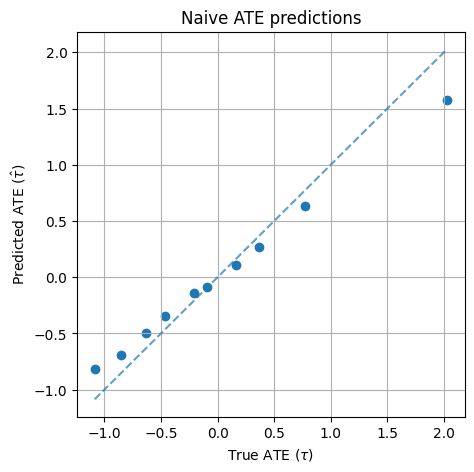

In [6]:
# Scatter plot: τ vs τ̂
plt.figure(figsize=(5, 5))
plt.scatter(tau, tau_hat)

# 45-degree reference line
lims = [
    min(tau.min(), tau_hat.min()),
    max(tau.max(), tau_hat.max())
]
plt.plot(lims, lims, "--", alpha=0.7)

plt.xlabel(r'True ATE ($\tau$)')
plt.ylabel(r'Predicted ATE ($\hat{\tau}$)')
plt.title('Naive ATE predictions')

plt.grid(True)
plt.show()

Over all, the model-derived $\hat{\tau}$ does seem to explain a lot of the signal in $\tau$, but something interesting has happened. For all almost all treatments, the estimate $\hat{\tau}_k$ is closer to zero than the true $\tau$. Why is that? the answer has to do with what we call "prediction  shrinkage".

Let's have a closer look at the distribution of observed values $y$ and predicted values $\hat{y}$

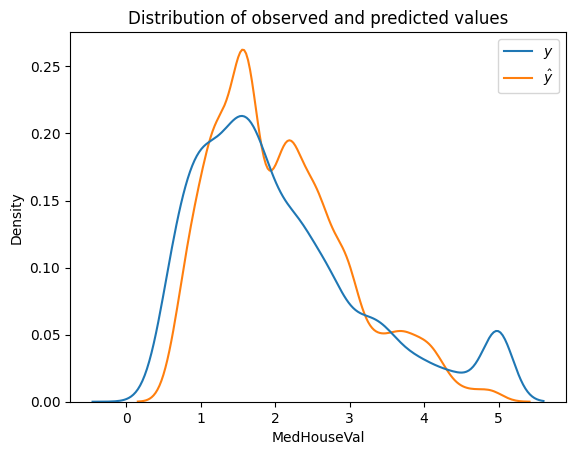

In [7]:
import seaborn as sns

n_test = len(y_test)

comp_data = pd.DataFrame({
    'MedHouseVal': np.concatenate([y_test, y_hat_test]),
    '': ([r'$y$'] * n_test + [r'$\hat{y}$'] * n_test)
    })

sns.kdeplot(data=comp_data, x='MedHouseVal', hue='')
plt.title('Distribution of observed and predicted values')
plt.show()

The predicted distribution is shrunk.

Include a better explanation alongside a plot like this:

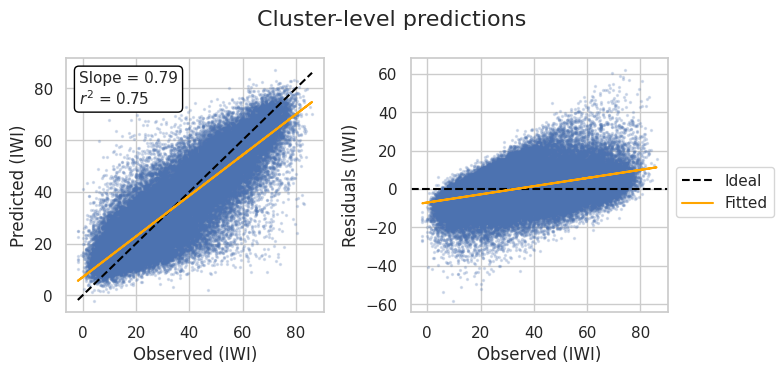

## Our solution: The Tweedie debiasing method

In [8]:
from unshrink import TweedieDebiaser

# Calibrate a Tweedie debiaser with the training data
y_hat_train = rf.predict(X_train)
tweedie = TweedieDebiaser().fit(y_hat_train, y_train)

tau_tweedie = []

for k in range(10):
    T_k = (T_group == k).astype(int)

    tau_tweedie_k = tweedie.debiased_ate(y_hat_test[T_k == 1], y_hat_test[T_k == 0])
    tau_tweedie.append(tau_tweedie_k)

tau_tweedie = np.array(tau_tweedie)

Naive slope: 0.776
Tweedie slope: 1.016
RMSE Naive: 0.194
RMSE Tweedie: 0.079


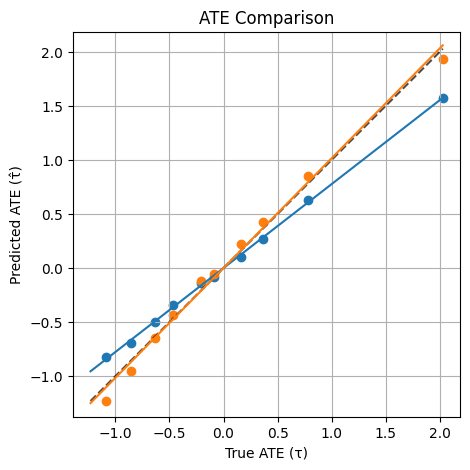

In [9]:
from sklearn.linear_model import LinearRegression

naive_reg = LinearRegression().fit(tau.reshape(-1, 1), tau_hat)
tweedie_reg = LinearRegression().fit(tau.reshape(-1, 1), tau_tweedie)

print(f'Naive slope: {naive_reg.coef_[0]:.3f}')
print(f'Tweedie slope: {tweedie_reg.coef_[0]:.3f}')

print(f'RMSE Naive: {np.sqrt(mean_squared_error(tau, tau_hat)):.3f}')
print(f'RMSE Tweedie: {np.sqrt(mean_squared_error(tau, tau_tweedie)):.3f}')

plt.figure(figsize=(5, 5))

# 45-degree reference line
lims = np.array([
    min(tau.min(), tau_hat.min(), tau_tweedie.min()),
    max(tau.max(), tau_hat.max(), tau_tweedie.max())
])
plt.plot(lims, lims, "k--", alpha=0.7)

# Plot predictions
plt.scatter(tau, tau_hat, label='Naive')
plt.scatter(tau, tau_tweedie, label='Tweedie corrected')

plt.plot(lims, naive_reg.predict(lims.reshape(-1, 1)))
plt.plot(lims, tweedie_reg.predict(lims.reshape(-1, 1)))

plt.xlabel("True ATE (τ)")
plt.ylabel("Predicted ATE (τ̂)")
plt.title("ATE Comparison")
plt.axis('equal')

plt.grid(True)
plt.show()

## Citation

If you use `unshrink` in your research, please cite:

```bibtex
@inproceedings{pettersson2025debiasingmachinelearningpredictions,
  title        = {Debiasing Machine Learning Predictions for Causal Inference Without Additional Ground Truth Data: One Map, Many Trials in Satellite-Driven Poverty Analysis},
  author       = {Markus Pettersson and Connor T. Jerzak and Adel Daoud},
  booktitle    = {Proceedings of the AAAI Conference on Artificial Intelligence (AAAI-26), Special Track on AI for Social Impact},
  year         = {2026},
}
```

Paper: [arXiv:2508.01341](https://arxiv.org/abs/2508.01341)